# Comparison between recommendations of pipeplines

This notebook shows the recommendations from different pipelines by scatter plotting the ucb scores/ucb ranks of the union set of top n recommendations from different pipelines.

Particularly, this notebook shows the comparison betweeen 
- recommendations from training sequences (average) and training samples (replicate labels)
- recommendations from different hyperparameters (alpha)

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012


In [4]:
run_new_experiment = True


if run_new_experiment:
    for alpha in [2]:
        top_n = Top_n_ucb(known_df, kernel_name='WD_Kernel_Shift', l=6, s=1, sigma_0 = 0.75,
                         embedding='label', alpha=alpha, rec_size=None, beta=1)

        top_n_rec_df = top_n.run_experiment()

        top_n_rec_df

        with pd.ExcelWriter('all_ucb_pred.xlsx', engine="openpyxl", mode='a') as writer:  
            top_n_rec_df.to_excel(writer, sheet_name='train_samples_alpha' + str(alpha) + 'sigma0_0.75')

X train shape:  (1055, 20)
X test shape:  (3961, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg


## Read prediction data; Plot ucb scores

Take two prediction list from different pipelines, take the union set of top n ucb scores, and scatter plot 
- the ucb scores for both pipeline predictions. x and y axis represents the predicted ucb scores from each pipeline, the same point represents the same sequence. 
- the rank of ucb scores (top UCB value is rank 1, the second rank 2, etc.) for both pipeline predictions. The units on the axis should be ranks (the plots will now be backwards, with the best items near the origin).



In [8]:
ucb_train_samples = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha0.1')
ucb_train_seqs = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_seq_alpha0.1')
ucb_train_samples_alpha6 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha6')
ucb_train_samples_alpha5 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha5')
ucb_train_samples_alpha4 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha4')
ucb_train_samples_alpha3 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha3')
ucb_train_samples_alpha2 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha2')
ucb_train_samples_alpha1 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha1')

ucb_train_samples_alpha2_sigma0_075 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha2sigma0_0.75')

In [9]:
def scatterplot_union_ucb_scores(df1, df2, df1_name, df2_name, rec_size = 90):
    """For two rec df from different pipelines,
    take the union set and scatter plot ucb scores.
    
    Input dataframe has at least two columns: index, ucb
    """
    union_rec_index = list(set(df1[:rec_size]['index']).union(set(df2[:rec_size]['index'])))
    print('union set size: ', len(union_rec_index))
    new_df1 = df1.loc[df1['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df2 = df2.loc[df2['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df1['rank'] = new_df1.index + 1
    new_df2['rank'] = new_df2.index + 1
    
    merge_df = new_df1.merge(new_df2, on = 'index')
    merge_df = merge_df.rename(columns = {'ucb_x': 'ucb_' + str(df1_name), 'ucb_y': 'ucb_' + str(df2_name),
                                         'rank_x': 'rank_' + str(df1_name), 'rank_y': 'rank_' + str(df2_name)})
    
    fig,a = plt.subplots(1, 2, figsize = (12,4))
    sns.scatterplot(x = 'ucb_'  + str(df1_name), y = 'ucb_' + str(df2_name), data = merge_df, ax = a[0])
    
    a[0].set_title('ucb scatter')
    sns.scatterplot(x = 'rank_' + str(df1_name), y = 'rank_' + str(df2_name), data = merge_df, ax = a[1])
    a[1].set_title('rank scatter')
    #a[1].set_xlim(-10,300)
    #a[1].set_ylim(-10,300)

### Train samples vs Train seqs

with same parameters (kernel_name='WD_Kernel_Shift', l=6, s=1, embedding='label', alpha=1, rec_size=None, beta=1)

We can see the top scores are similar for both approach, while the lower scores are differs in a smaller scale (~ 0.5). This means training with samples (multiples scores) and training with sequences (average score) give similar recommendations. 

union set size:  126


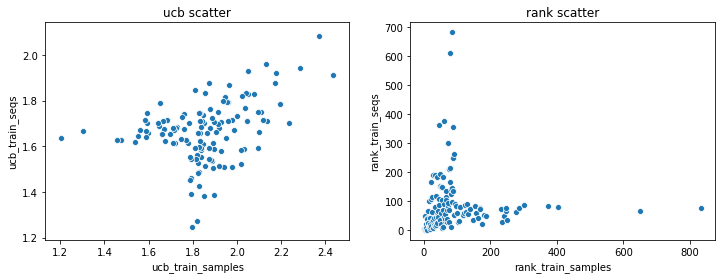

In [6]:
scatterplot_union_ucb_scores(ucb_train_samples, ucb_train_seqs, 'train_samples', 'train_seqs')

### Train samples with different alphas

with same other parameters (kernel_name='WD_Kernel_Shift', l=6, s=1, embedding='label', rec_size=None, beta=1)

From the repeated kfold results, alpha = 6 is a reasonable good choice in terms of testing performance. 
But I suggest to select alpha not too big, although large alpha seems to give better performance score. Since adding alpha make the predictions concentrates more on 0 (smaller range; regression to mean).
So the idea is to gradually compare smaller alpha value to bigger, i.e. compare 5 and 6; 4 and 5, etc. 
And then selecting the smallest alpha as possible. 

#### alpha = 5 vs. alpha =6

union set size:  95


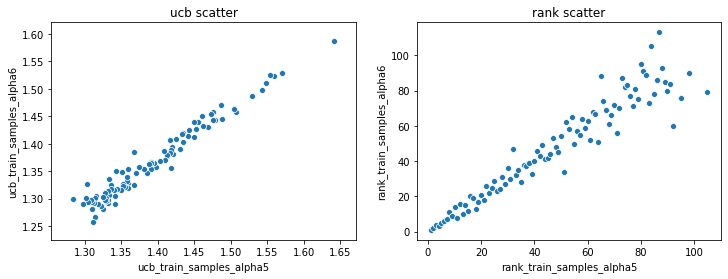

In [7]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha5, ucb_train_samples_alpha6, 'train_samples_alpha5', 'train_samples_alpha6')

conclusion: alpha = 5 and alpha = 6 gives similar recommendations.

#### alpha = 4 vs alpha = 5

union set size:  95


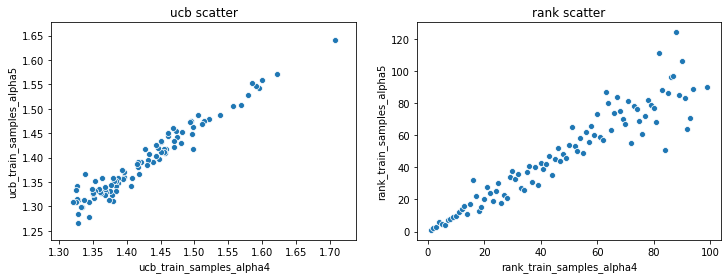

In [8]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha4, ucb_train_samples_alpha5, 'train_samples_alpha4', 'train_samples_alpha5')

conclusion: alpha = 4 and alpha = 5 gives similar recommendations.

#### alpha = 3 vs. alpha =4

union set size:  95


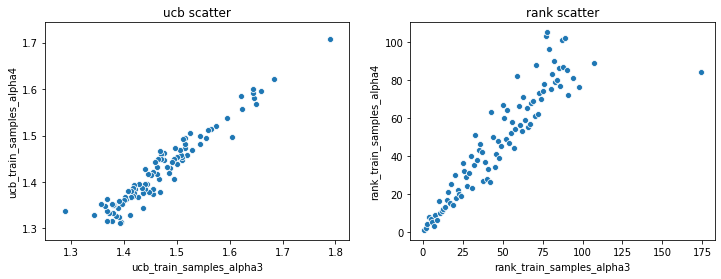

In [9]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha3, ucb_train_samples_alpha4, 'train_samples_alpha3', 'train_samples_alpha4')

conclusion: alpha = 3 and alpha = 4 gives similar recommendations.

#### alpha = 2 vs. alpha =3

union set size:  96


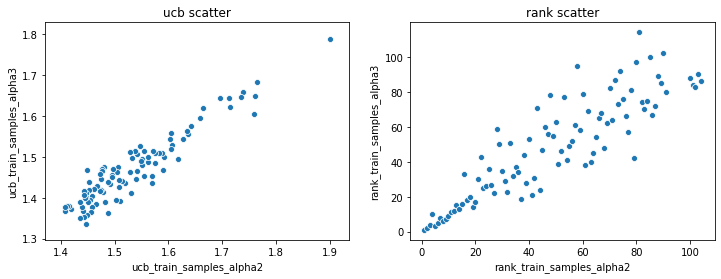

In [10]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha2, ucb_train_samples_alpha3, 'train_samples_alpha2', 'train_samples_alpha3')

conclusion: alpha = 2 and alpha = 3 gives similar recommendations (although the order inside of top 90 are a little bit different)

So seems like alpha = 2 is a reasonable choice. 
#### Let's check alpha =2 vs alpha = 6

union set size:  110


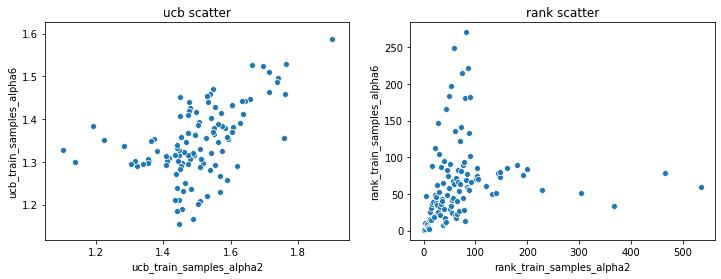

In [11]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha2, ucb_train_samples_alpha6, 'train_samples_alpha2', 'train_samples_alpha6')

Also check alpha = 2, 1, 0.1

#### alpha = 1 vs. alpha =2

union set size:  105


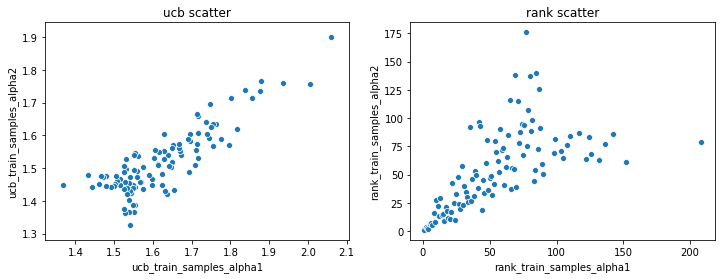

In [12]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha1, ucb_train_samples_alpha2, 'train_samples_alpha1', 'train_samples_alpha2')

The alpha values smaller than 2 seems to change the prediction more than above. We show the comparisons for several groups

#### alpha = 1 vs. alpha =0.1

union set size:  113


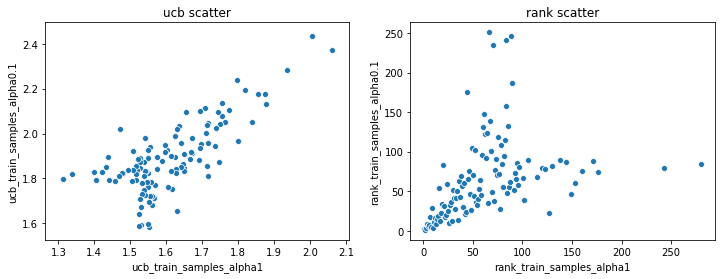

In [13]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha1, ucb_train_samples, 'train_samples_alpha1', 'train_samples_alpha0.1')

#### alpha = 6 vs. alpha =0.1

union set size:  141


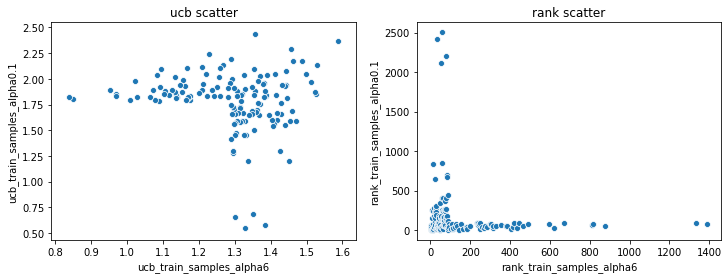

In [14]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha6, ucb_train_samples, 'train_samples_alpha6', 'train_samples_alpha0.1')

## alpha= 2 & simga0 = 1 vs alpha = 2 & sigma0 = 0.75

sigma0 is the hyperparameter of kernel, signal std, the value multiplied to the normalised kernel.  
According to kfold, sigma0 = 0.75 & alpha = 6 gives a good test performance.  
So check whether changing sigma influence the recommendation a lot.   
From the result, the sigma0 does not influence the recommendation a lot, so we decide to stil choose sigma0 = 1.

union set size:  96


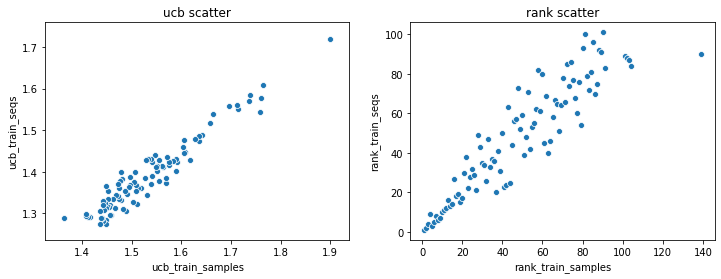

In [10]:
scatterplot_union_ucb_scores(ucb_train_samples_alpha2, ucb_train_samples_alpha2_sigma0_075, 'train_samples', 'train_seqs')

## Fix alpha = 2, Comparsion with different beta

For the above analysis, we fix beta = 1, i.e. mean + beta * std with beta = 1.
From above comparison for different alpha values, we select alpha = 2 (a finer tuning can be done between 1 and 3).
Now we 

In [15]:
selected_rec = ucb_train_samples_alpha2.copy()

for beta in [0, 2, 3, 4, 5]:
    selected_rec['ucb_beta' + str(beta)] = selected_rec['pred mean'] + beta * selected_rec['pred std']

selected_rec['ucb_std_only'] = selected_rec['pred std']
selected_rec = selected_rec.rename(columns = {'ucb': 'ucb_beta1'})    

In [16]:
selected_rec[:90]

,Unnamed: 0,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,...,label,pred mean,pred std,ucb_beta1,ucb_beta0,ucb_beta2,ucb_beta3,ucb_beta4,ucb_beta5,ucb_std_only
0,3561,3385,NaN,NaN,NaN,TTTAAGATGCTATTATACAT,TGCTAT,NaN,NaN,NaN,...,NaN,1.148037,0.751929,1.899966,1.148037,2.651895,3.403824,4.155753,4.907682,0.751929
1,2569,2393,NaN,NaN,NaN,TTTAAGACGCTATTATACAT,CGCTAT,NaN,NaN,NaN,...,NaN,1.022734,0.742352,1.765087,1.022734,2.507439,3.249791,3.992143,4.734495,0.742352
2,3563,3387,NaN,NaN,NaN,TTTAAGATGCTGGTATACAT,TGCTGG,NaN,NaN,NaN,...,NaN,0.993331,0.767460,1.760791,0.993331,2.528251,3.295711,4.063171,4.830631,0.767460
3,3560,3384,NaN,NaN,NaN,TTTAAGATGCTACTATACAT,TGCTAC,NaN,NaN,NaN,...,NaN,0.992106,0.766318,1.758424,0.992106,2.524743,3.291061,4.057379,4.823697,0.766318
4,2072,1896,NaN,NaN,NaN,TTTAAGAGTCTATTATACAT,GTCTAT,NaN,NaN,NaN,...,NaN,1.000676,0.738051,1.738727,1.000676,2.476777,3.214828,3.952879,4.690930,0.738051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1824,1648,NaN,NaN,NaN,TTTAAGAGCCTGTTATACAT,GCCTGT,NaN,NaN,NaN,...,NaN,0.742163,0.700238,1.442401,0.742163,2.142639,2.842877,3.543115,4.243353,0.700238
86,3481,3305,NaN,NaN,NaN,TTTAAGATGGCATTATACAT,TGGCAT,NaN,NaN,NaN,...,NaN,0.728468,0.713925,1.442393,0.728468,2.156318,2.870244,3.584169,4.298094,0.713925
87,1761,1585,NaN,NaN,NaN,TTTAAGAGCGTGCTATACAT,GCGTGC,NaN,NaN,NaN,...,NaN,0.698248,0.742605,1.440853,0.698248,2.183458,2.926063,3.668668,4.411273,0.742605
88,1740,1564,NaN,NaN,NaN,TTTAAGAGCGCAGTATACAT,GCGCAG,NaN,NaN,NaN,...,NaN,0.649642,0.788999,1.438641,0.649642,2.227640,3.016638,3.805637,4.594636,0.788999


In [17]:
pd.set_option('mode.chained_assignment', None) # Turn off warnings

def scatterplot_for_diff_beta(df, name1, name2, rec_size = 90):
    """For the rec df pred mean and std, generating ucb with different beta 
    take the union set and scatter plot ucb scores.
    
    Input dataframe has at least two columns: index, ucb
    """
    df1 = df[['index', 'ucb_' + str(name1)]].copy()
    df1 = df1.sort_values(by = 'ucb_' + str(name1), ascending = False).reset_index()
    df2 = df[['index', 'ucb_' + str(name2)]].copy()
    df2 = df2.sort_values(by = 'ucb_' + str(name2), ascending = False).reset_index()
    
    union_rec_index = list(set(df1[:rec_size]['index']).union(set(df2[:rec_size]['index'])))
    print('union set size: ', len(union_rec_index))
    new_df1 = df1.loc[df1['index'].isin(union_rec_index)]
    new_df2 = df2.loc[df2['index'].isin(union_rec_index)]
    new_df1['rank'] = new_df1.index + 1
    new_df2['rank'] = new_df2.index + 1
    
    merge_df = new_df1.merge(new_df2, on = 'index')
    merge_df = merge_df.rename(columns = {'ucb_x': 'ucb_' + str(name1), 'ucb_y': 'ucb_' + str(name2),
                                         'rank_x': 'rank_' + str(name1), 'rank_y': 'rank_' + str(name2)})
#     print(merge_df)
    fig,a = plt.subplots(1, 2, figsize = (12,4))
    sns.scatterplot(x = 'ucb_'  + str(name1), y = 'ucb_' + str(name2), data = merge_df, ax = a[0])   
    a[0].set_title('ucb scatter ' + str(name1) + ' vs ' + str(name2))
    sns.scatterplot(x = 'rank_' + str(name1), y = 'rank_' + str(name2), data = merge_df, ax = a[1])
    a[1].set_title('rank scatter' + str(name1) + ' vs ' + str(name2))
    #a[1].set_xlim(-10,300)
    #a[1].set_ylim(-10,300)

We first show the histogram of the predicted mean and std of the top 90 ucb recommendations. 
We can see the range of pred std is smaller. 

Text(0.5, 1.0, 'Top 90 UCB pred std hist')

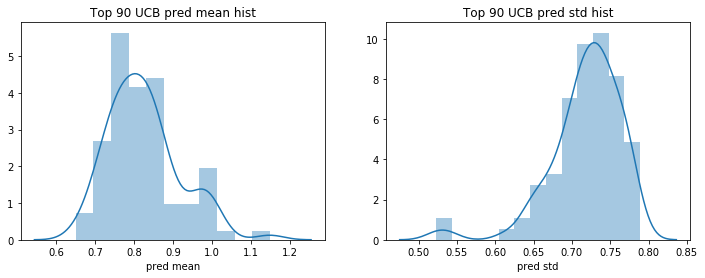

In [18]:
fig,a = plt.subplots(1, 2, figsize = (12,4))
sns.distplot(selected_rec['pred mean'][:90], ax = a[0])
a[0].set_title('Top 90 UCB pred mean hist')
sns.distplot(selected_rec['pred std'][:90], ax = a[1])
a[1].set_title('Top 90 UCB pred std hist')

### beta = 1 vs. pred mean

beta = 1 gives similar recommendations to only using pred mean, and (almost) totally different from pred std.

union set size:  101


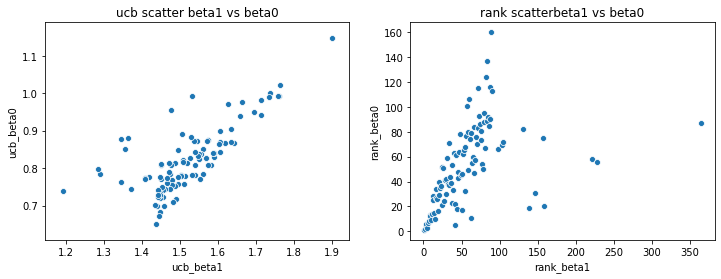

In [19]:
scatterplot_for_diff_beta(selected_rec, 'beta1', 'beta0')

union set size:  169


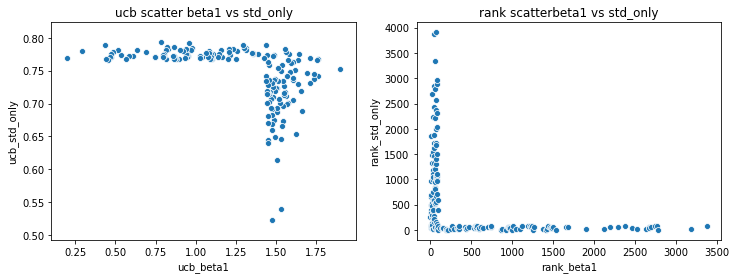

In [20]:
scatterplot_for_diff_beta(selected_rec, 'beta1', 'std_only')

### beta = 5 vs. pred mean/std

seems an appropriate value for beta would between 1 and 5.

union set size:  132


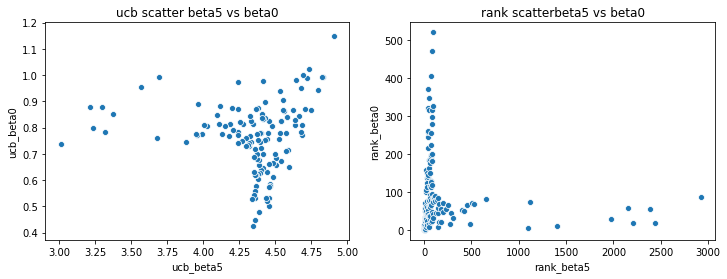

In [21]:
scatterplot_for_diff_beta(selected_rec, 'beta5', 'beta0')

union set size:  157


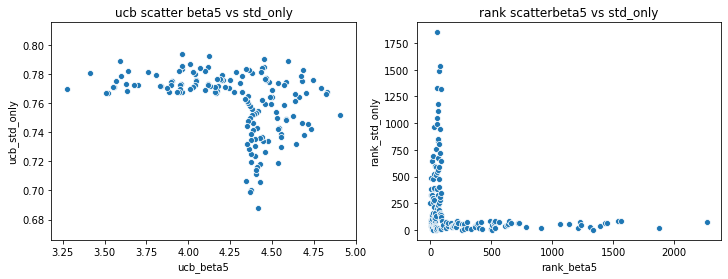

In [22]:
scatterplot_for_diff_beta(selected_rec, 'beta5', 'std_only')

### beta = 1 vs. beta = 2,3,4,5

union set size:  101


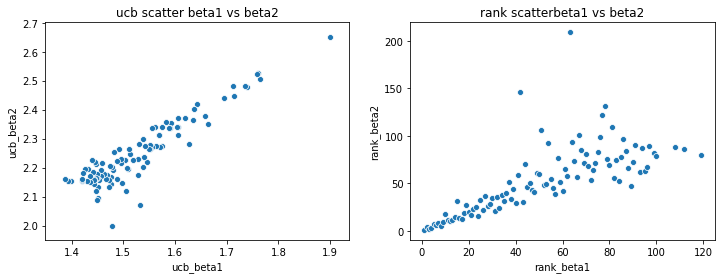

In [23]:
scatterplot_for_diff_beta(selected_rec, 'beta1', 'beta2')

union set size:  109


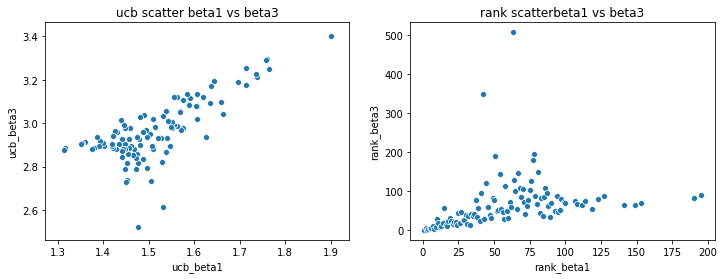

In [24]:
scatterplot_for_diff_beta(selected_rec, 'beta1', 'beta3')

union set size:  117


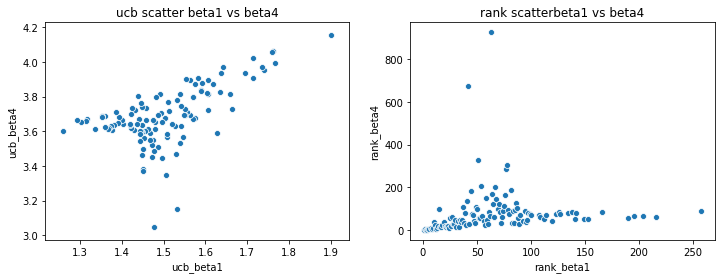

In [25]:
scatterplot_for_diff_beta(selected_rec, 'beta1', 'beta4')

union set size:  122


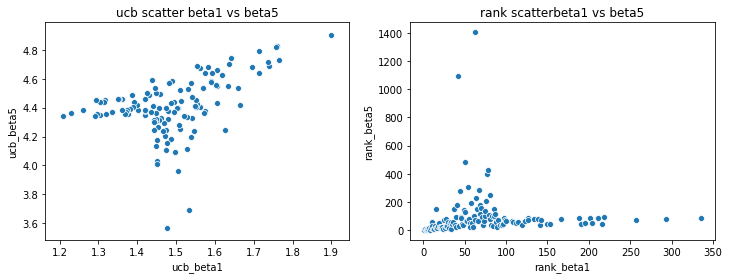

In [26]:
scatterplot_for_diff_beta(selected_rec, 'beta1', 'beta5')

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90